So this one is for assignment 3 this week which is using deltaR between the event with n (and/or one with pi+) and the various clusters. Then minimize that to find the cluster that most likely contains the n (this is for delta+ I guess? Then do again for pi0 and p) 

Will be plotting the response plot (those predictions) of that one cluster specifically! Then compare these to the single pion sample.

This is the one that works, inexplicably. No idea why, I can't tell what I'm doin differently, I just hit undo until I got back to the format that worked. looks identical to something I tried later and didn't work but who cares. I'm gonna clean this notebook up but you can go look at the notworking one for the preserved mess if you want!

In [1]:
#imports
import uproot as ur
import awkward as ak
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6" #specify GPU
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import graph_util as gu
import plot_util as pu

from scipy.interpolate import interp1d

from Week7_PFNutils import *

2021-07-27 08:33:23.928013: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-27 08:33:37.406869: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-27 08:33:37.428386: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-27 08:33:37.573630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-27 08:33:37.573695: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-27 08:33:37.630784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

In [2]:
model_path = '/fast_scratch/atlas_images/v01-45/' 
data_path = '/data/atlas/'

In [3]:
import vector as v

import atlas_mpl_style as ampl #makes matplotlib follow atlas formal style
ampl.use_atlas_style()

v.register_awkward()

In [4]:
events = ur.open(model_path+'delta_medium.root')

tree = events['EventTree']

In [5]:
brnch = ['cluster_hitsTruthE', 'cluster_hitsTruthIndex', 'truthPartPdgId', 'truthPartEta', 'truthPartPhi', 
         'truthPartPt', 'truthPartMass', 'cluster_E', 'cluster_Eta', 'cluster_Phi','cluster_Pt']

In [6]:
branches = tree.arrays(expressions=brnch)

In [7]:
truthE = branches.cluster_hitsTruthE
truthIndex = branches.cluster_hitsTruthIndex
truthID = branches.truthPartPdgId
trutheta = branches.truthPartEta
truthphi = branches.truthPartPhi
truthpt = branches.truthPartPt
truthmass = branches.truthPartMass
clusE = branches.cluster_E
clusEta = branches.cluster_Eta
clusPhi = branches.cluster_Phi
clusPt = branches.cluster_Pt

In [8]:
#start with just the delta+ -> n + pi+
nnopind = []    

for i in range(len(truthID)): #basically: delta+, two categories: pip & n (without any ps) vs pi0 & p (no ns)
    if (2214 in truthID[i]) & ~(2212 in truthID[i]) & (2112 in truthID[i]) & (211 in truthID[i]):
        nnopind.append(i)
        
flag = np.zeros(len(truthID))
flag[nnopind] = 2

In [9]:
mask = flag == 2

In [12]:
cell_id = tree['cluster_cell_ID'].array()

In [14]:
#try this here: need to examine shape, compare to shape of clusterEta?
len(cell_id)

200000

In [15]:
cell_id_msk = cell_id[mask]
len(cell_id_msk)

8289

In [17]:
len(ak.flatten(cell_id_msk))

30788

In [23]:
len(ak.flatten(cell_id_msk)[0]), len(ak.flatten(clusEta_sel))

TypeError: object of type 'float' has no len()

In [30]:
cell_id_msk[0][mindist_indices[0]]

<Array [814895104, 814899200, ... 823283712] type='7 * int64'>

In [22]:
truthE_sel = truthE[mask]
truthIndex_sel = truthIndex[mask]
truthID_sel = truthID[mask]
trutheta_sel = trutheta[mask]
truthphi_sel = truthphi[mask]
truthpt_sel = truthpt[mask]
truthmass_sel = truthmass[mask]
clusE_sel = clusE[mask]
clusEta_sel = clusEta[mask]
clusPhi_sel = clusPhi[mask]
clusPt_sel = clusPt[mask]

In [24]:
clusmass_sel = []
for i in range(len(clusE_sel)):
    clusmass_sel.append(np.zeros(len(clusE_sel[i])))#okay great this is how to get it the right shape:))

In [25]:
clusEta_sel[0], trutheta_sel[0] #so there are 4 particles, two clusters.....
#for each event, using only the n, loop through the clusters and keep the closest one. okay

(<Array [-1.96, 1.79] type='2 * float32'>,
 <Array [-2.21, -1.81, -2.12, -2.13] type='4 * float32'>)

# I HAVE NO IDEA 

Update: figured it out

In [26]:
mindist_indices = []
for i in range(len(trutheta_sel)): #loop through each event, this does take a while to run but its so fragile 
                                                                            #I wont change it
    #select the neutron:
    n_mask = truthID_sel[i] == 2112
    
    #then get deltaR for n
    partvec = ak.zip({
        "pt": truthpt_sel[i][n_mask],
        "eta": trutheta_sel[i][n_mask],
        "phi": truthphi_sel[i][n_mask],
        "mass": truthmass_sel[i][n_mask],
    })
    
    part4Dvec = ak.with_name(partvec, "Momentum4D")
    
    #and for the cluster
    deltaR = []
    for j in range(len(clusEta_sel[i])):
        clusvec = ak.zip({
            "pt": clusPt_sel[i][j],
            "eta": clusEta_sel[i][j],
            "phi": clusPhi_sel[i][j],
            "mass": clusmass_sel[i][j]})
        clus4Dvec = ak.with_name(clusvec, "Momentum4D")
        
        deltaR.append(part4Dvec.deltaR(clus4Dvec))
        #print(deltaR)
        #print(i,j)
        if deltaR == []:
            print('exception: empty deltaR') #okay so this does work I just needed to restart the kernel:))
            print(part4Dvec, clus4Dvec, part4Dvec.deltaR(clus4Dvec), deltaR, i, j)
        ind = np.argmin(np.array(ak.flatten(deltaR)))# np.where(deltaR == min(np.ravel(np.array(deltaR))))
        #print(ind)
         #that should just be it?? this is the index of that cluster
    mindist_indices.append(ind)

In [28]:
len(mindist_indices), len(trutheta_sel), len(ak.flatten(clusEta_sel)) #yes !!! okay!!!

(8289, 8289, 30788)

In [29]:
clusEta_sel[0][mindist_indices[0]]

-1.9553970098495483

In [15]:
clusEta_sel[18], clusmass_sel[18], clusPhi_sel[18]

(<Array [] type='0 * float32'>,
 array([], dtype=float64),
 <Array [] type='0 * float32'>)

In [16]:
k = [2, 6, 8]

kclus = clusEta_sel[:10]

print(len(kclus[k]))

3


In [31]:
#remove the empty ones
mindist_indices_full = []
truthID_sel_full = []
trutheta_sel_full = [] #also removes all the events/truth particles in the events with no clusters
truthphi_sel_full = []
truthpt_sel_full = []
truthmass_sel_full = []
clusE_sel_full = []
clusEta_sel_full =[]
clusPhi_sel_full = []
clusPt_sel_full = []
clusmass_sel_full = []
cell_id_full = []
for i in range(len(clusEta_sel)): #should there be this many with no clusters!!??!?!
    if len(clusEta_sel[i]) != 0: #sure. so need to filter out all these !
        mindist_indices_full.append(mindist_indices[i])
        truthID_sel_full.append(truthID_sel[i])
        trutheta_sel_full.append(trutheta_sel[i])
        truthphi_sel_full.append(truthphi_sel[i])
        truthpt_sel_full.append(truthpt_sel[i])
        truthmass_sel_full.append(truthmass_sel[i])
        clusE_sel_full.append(clusE_sel[i])
        clusEta_sel_full.append(clusEta_sel[i])
        clusPhi_sel_full.append(clusPhi_sel[i])
        clusPt_sel_full.append(clusPt_sel[i])
        clusmass_sel_full.append(clusmass_sel[i])
        cell_id_full.append(cell_id_msk[i])

In [32]:
clusEta_closest = []
clusE_closest = [] #select only the closest clusters
clusPhi_closest = []
clusPt_closest = []
clusmass_closest = []
cellid_closest = []
for i in range(len(clusEta_sel_full)):
    #print(clusEta_sel_full[i], mindist_indices_full[i])
    clusEta_closest.append(clusEta_sel_full[i][mindist_indices_full[i]])
    clusE_closest.append(clusE_sel_full[i][mindist_indices_full[i]])
    clusPhi_closest.append(clusPhi_sel_full[i][mindist_indices_full[i]])
    clusPt_closest.append(clusPt_sel_full[i][mindist_indices_full[i]])
    clusmass_closest.append(clusmass_sel_full[i][mindist_indices_full[i]])
    cellid_closest.append(cell_id_full[i][mindist_indices_full[i]])

In [34]:
cellid_closest[0], clusEta_closest[0] #so multiple cells per cluster

(<Array [814895104, 814899200, ... 823283712] type='7 * int64'>,
 -1.9553970098495483)

In [35]:
cellidPad = ak.pad_none(cellid_closest, 2000, axis=1)

In [37]:
cellidPad

<Array [[814895104, 814899200, ... None, None]] type='7666 * var * ?int64'>

In [19]:
len(ak.Array(clusEta_closest))

7666

In [10]:
import convert_sets_splitdelta as cs

In [11]:
cs.doit(mask, data_path+'throwaway', 211, 2112) #just to test/compare, to see what I'm aiming for:
#and recall this didn't work since I had removed the longflag thing for deltaR, so it's too short here. 

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
deltaR 8289
loadarraybranchflat
8289
8289 [[814895104, 814899200, 814632960, 814628864, ... 856219648, 856223744, 864604160]]
flat 30788
flatnumpy 30788
--
loadarraybranchflat
8289
8289 [[5.32, 0.17, 0.452, 0.0711, 0.415, 0.273, ... 0.0541, 0.4, 0.0412, 0.572, 0.597]]
flat 30788
flatnumpy 30788
--
cell_e 30788
cell_id 30788
30788
30788
30788
30788
30788
30788
cell_eta 30788
clus_eta 30788
cell eta (30788, 2000)
clus eta (30788,)
clus eta none (30788, 1)
30788 8289 30788
Normalizing


/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:79: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out


ValueError: in NumpyArray attempting to get 8289, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.4.0/src/cpu-kernels/awkward_regularize_arrayslice.cpp#L18)

In [11]:
cs.doit_cc(mask, data_path+'w12_closestcluster', 211, 2112) #here goes nothing

Working on /fast_scratch/atlas_images/v01-45/delta_medium.root
Loading data
clusEta_sel 8289
full inds 7666
loadarraybranchflat
8289
7666 [[814895104, 814899200, 814632960, 814628864, ... 856219648, 856223744, 864604160]]
flat !!!!!?? 7666
flatnumpy 7666
--
loadarraybranchflat
8289
7666 [[5.32, 0.17, 0.452, 0.0711, 0.415, 0.273, ... 0.0541, 0.4, 0.0412, 0.572, 0.597]]
flat !!!!!?? 7666
flatnumpy 7666
--
cell_id !!?? 7666
cell_e !!?! 7666
7666
7666
7666
7666
7666
7666
cell eta 7666
cell phi 7666
eta [-1.95539701  1.76976109 -1.9589355  -2.40188622 -1.43394566 -2.00725865
 -2.23797679 -1.62925625 -1.7706058  -1.83841276] 7666
pt [ 1.6196028  35.70428848  1.43032336  1.62084162  1.30188441 16.67948723
 91.53089142 52.27288437  0.45405436  3.85772705] 7666
e [  5.83723688 107.82382202   5.17260885   9.02365875   2.88600826
  63.19226074 433.90310669 138.4226532    1.37229776  12.43272495] 7666
7666 7666 7666
7666 7666 [[-1.95539701]
 [ 1.76976109]
 [-1.9589355 ]
 ...
 [ 1.02326369]
 [-1.06

/home/kaelaekd/start_tf/LCStudies/classifier/convert_sets_splitdelta.py:203: RuntimeWarning: divide by zero encountered in log
  cell_e = np.nan_to_num(np.log(cell_e), posinf = 0, neginf=0)


Writing out
Done! /data/atlas/w12_closestcluster


In [ ]:
len(mask)

In [ ]:
trutheta[mask]

In [ ]:
branches.cluster_cell_ID[mask]

In [12]:
x = np.array([1,2,3])

In [15]:
x.shape

(3,)

In [13]:
#!!!!!!!!!!! Can't believe it!! moment of truth tho, lets see if it works:
file = np.load(data_path+'w12_closestcluster.npz')
model_nog = tf.keras.models.load_model(model_path+'w8_pfn_noglob_2.hdf5')

In [16]:
X = file['X']
clus_eta = file['clus_eta']
clus_pt = file['clus_pt']
clus_E = file['clus_e']
clus_et = file['clus_e_t']
deltar = file['deltaR']


In [17]:
def doit(dat, outfile, size):
    X, clus_eta, clus_pt, clus_E, clus_et, deltar = dat
    X_all = np.array(X[:size])
    eta_all = np.array(clus_eta[:size])
    pt_all = np.array(clus_pt[:size])
    E_all = np.array(clus_E[:size])
    et_all = np.array(clus_et[:size])
    deltar_all = np.array(deltar[:size])
    
    (X_train, X_val, X_test,  
     eta_train, eta_val, eta_test, 
     ET_train, ET_val, ET_test, 
     pt_train, pt_val, pt_test, 
     Eng_train, Eng_val, Eng_test,
     deltar_train, deltar_val, deltar_test) = data_split(X_all, eta_all, et_all, pt_all, E_all, deltar_all, val=100, test=int(size/2.))
    
    np.savez(data_path+outfile, X_train, X_val, X_test, eta_train, eta_val, eta_test, ET_train, ET_val, ET_test, pt_train, pt_val, pt_test, Eng_train, Eng_val, Eng_test, deltar_train, deltar_val, deltar_test)

In [18]:
len(X)

7359

In [19]:
doit((X, clus_eta, clus_pt, clus_E, clus_et, deltar), 'nn_closestcluster.npz', 7359)

In [20]:
NNfile = np.load(data_path+'nn_closestcluster.npz')


In [23]:
import Week7_PFNutils as W

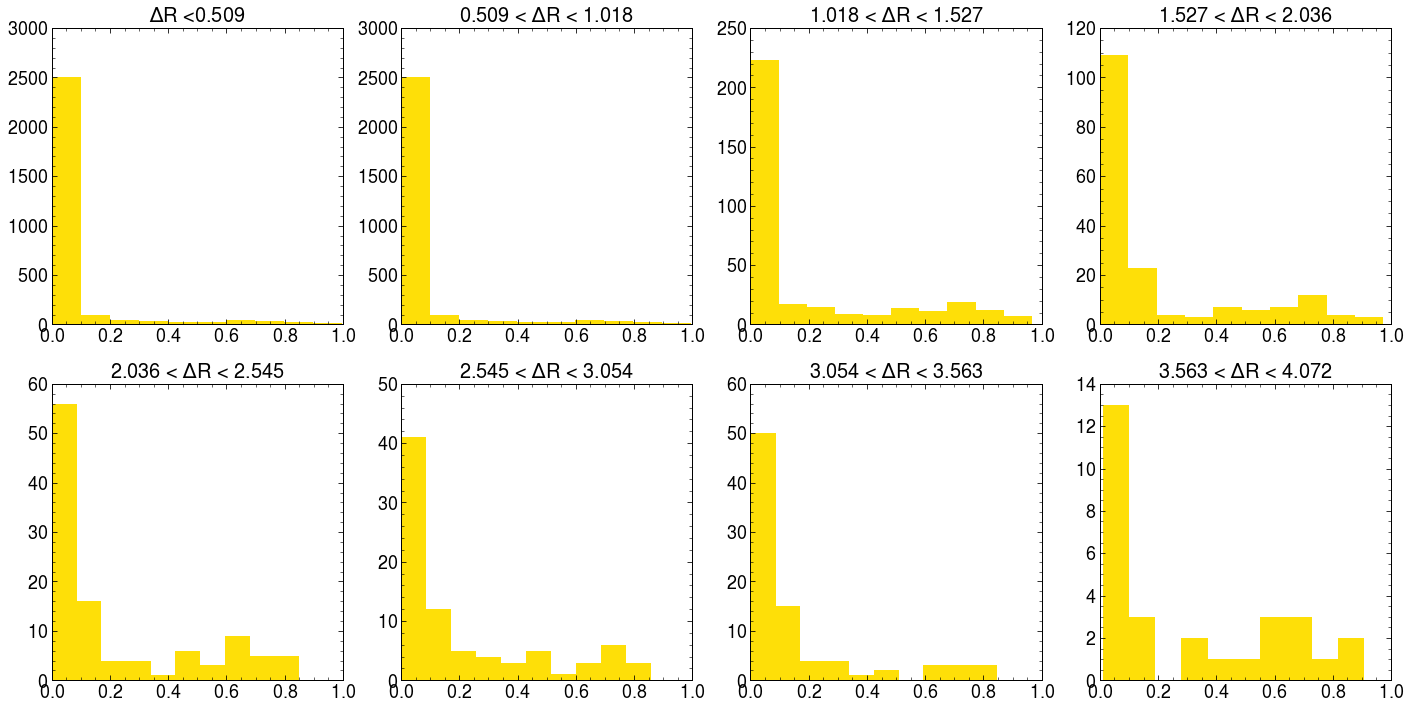

In [25]:
W.deltaR_responseplots(NNfile, model_nog, col='xkcd:dandelion') #this one is closest to the n, DONT REDO!! file has been replaced by one with closest to the pi+!!***